# AiiDA 
This implementation uses AiiDA to implement the equation of state workflow with Quantum ESPRESSO.
It intentionally provides a minimal implementation for the sake of simplicity:

* Quantum ESPRESSO is run locally, but could be run on a remote cluster
* Not all steps of the procedure are captured by provenance, just the Quantum ESPRESSO calculations
* The entire procedure is not yet wrapped up in a single workflow
* The SCF calculations are run serially but could be run in parallel

## Installation and setup
```
pip install aiida-core[atomic-tools]
pip install aiida-shell
verdi presto
```


In [1]:
from aiida import load_profile

load_profile()

Profile<uuid='86fefa9b455f4880ac9746dc8994ddbe' name='test'>

## Implementation of a new simulation code

AiiDA allows developers to implement complex interfaces for any external code, with features such as input validation, error handling etc.
However, if you just want to run an external code without too much faff, you can use `aiida-shell` to do so.

In [2]:
from pathlib import Path

from ase.build import bulk
from aiida.orm import SinglefileData

from functions import write_input

FILEPATH_PSEUDOS = Path.cwd() / 'espresso' / 'pseudo'
pseudopotentials = {"Al": "Al.pbe-n-kjpaw_psl.1.0.0.UPF"}

input_string = write_input(
    input_dict={
        "structure": bulk('Al'), 
        "pseudopotentials": pseudopotentials, 
        "kpts": (3, 3, 3),
        "calculation": "vc-relax",
        "smearing": 0.02,
        },
    return_string=True
)

Although the `pw.x` executable can be run without any parsing, let's add a parser that converts the outputs into AiiDA nodes to improve the richness of the provenance:

In [3]:
from aiida import orm
from adis_tools.parsers import parse_pw

def pw_parser(dirpath):
    
    parsed_data = parse_pw(dirpath / 'pwscf.xml')

    return {
        'structure': orm.StructureData(ase=parsed_data['ase_structure']),
        'energy': orm.Float(parsed_data['energy']),
        'volume': orm.Float(parsed_data['ase_structure'].get_volume()),
    }

Now it's time to run the relaxation:

In [4]:
from aiida_shell import launch_shell_job

results_relax, node_relax = launch_shell_job(
    'pw.x',
    arguments='-in {input_file}',
    parser=pw_parser,
    nodes={
        'input_file': SinglefileData.from_string(input_string, filename='input.pwi'),
    },
    outputs=['pwscf.xml', ],
    metadata={
        'options': {
            'prepend_text': f'export ESPRESSO_PSEUDO {FILEPATH_PSEUDOS.as_posix()}',
            'redirect_stderr': True
        }
    }
)

## EOS

In [5]:
from functions import generate_structures

scaled_structures = generate_structures(
    results_relax['structure'].get_ase(), [0.9, 0.95, 1.0, 1.05, 1.1])

structures = []
energies = []

scf_inputs = {
    "pseudopotentials": pseudopotentials, 
    "kpts": (3, 3, 3),
    "calculation": "scf",
    "smearing": 0.02,
}

for scaled_structure in scaled_structures:

    scf_inputs['structure'] = scaled_structure
    input_string = write_input(scf_inputs, return_string=True)

    results_scf, node_scf = launch_shell_job(
        'pw.x',
        arguments='-in {input_file}',
        parser=pw_parser,
        nodes={
            'input_file': SinglefileData.from_string(input_string, filename='input.pwi'),
        },
        outputs=['pwscf.xml', ],
        metadata={
            'options': {
                'prepend_text': f'export ESPRESSO_PSEUDO {FILEPATH_PSEUDOS.as_posix()}',
                'redirect_stderr': True
            }
        }
    )

    structures.append(results_scf['structure'].get_ase())
    energies.append(results_scf['energy'].value)

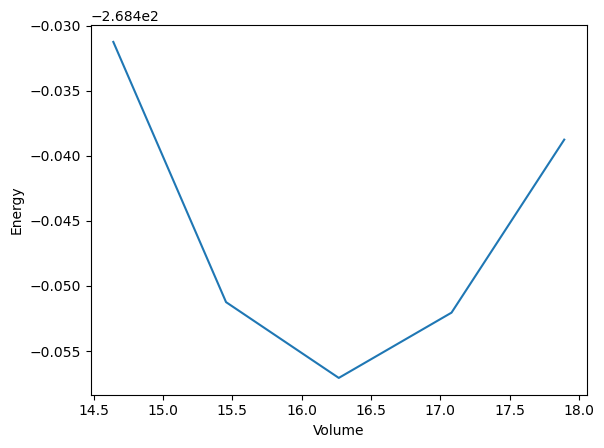

In [6]:
import matplotlib.pyplot as plt
volumes = [structure.get_volume() for structure in structures]

plt.plot(volumes, energies)
plt.xlabel('Volume')
plt.ylabel('Energy')
plt.savefig('evcurve.png')

## Submission to an HPC / Check pointing / Error handling
To be added...

## Data Storage / Data Sharing
To be added...

## Publication of the workflow
To be added...